In [40]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [41]:
from sklearn.datasets import load_boston
boston = load_boston()

c:\Users\JassleenBhullar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [42]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names

In [43]:
data['PRICE'] = boston.target

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [160]:
X, y = data.iloc[:, :-1],data.iloc[:,-1:]
X = X.loc[:, X.columns != 'LSTAT']

In [161]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

### linear regression in xgboost

In [162]:
from sklearn.metrics import mean_squared_error

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
# print(rmse)
xg_reg.score(X_test, y_test)

0.7066222391351165

In [219]:
# finding the best parameters for model
from sklearn.model_selection import GridSearchCV
# parameter grid
gbm_param_grid = {
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [1],
    'subsample': [0.3, 0.5, 0.7],
    'n_estimators': [50, 70],
    'max_depth': [4,6],
    'alpha' : [0],
    'num_parallel_tree' : [1]
    }
# regressor instance
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(
    estimator = gbm,
    param_grid = gbm_param_grid,
    scoring = 'r2',
    cv = 5,
    verbose = 1
)
grid_mse.fit(X, y)
print('Best params', grid_mse.best_params_)
print('Best score:', grid_mse.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params {'alpha': 0, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 70, 'num_parallel_tree': 1, 'subsample': 0.3}
Best score: 0.6891860925500207


tuned model

In [217]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', alpha = 0, colsample_bytree = 1, learning_rate = 0.1, max_depth = 4, n_estimators = 70, num_parallel_tree = 1, subsample = 0.3)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
# print(rmse)
xg_reg.score(X_test, y_test)

0.7242742006279891

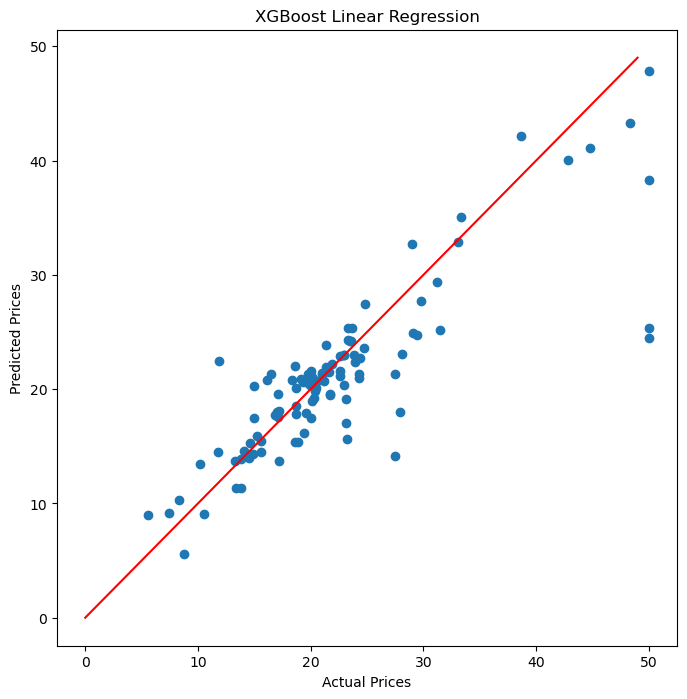

In [222]:
plt.scatter(y_test, preds)
plt.title('XGBoost Linear Regression')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot(range(50), range(50), color='red');

### cross-validation

In [97]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


In [98]:
cv.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.744826,0.123787,21.750077,0.547540
1,19.804627,0.109432,19.851135,0.555528
2,18.025926,0.078519,18.093845,0.553064
3,16.444088,0.059621,16.532366,0.491367
4,15.004173,0.084522,15.131969,0.483508


In [99]:
print((cv["test-rmse-mean"]).tail())
# print((cv['test-rmse-std']))

45    3.889576
46    3.862198
47    3.851643
48    3.836491
49    3.825175
Name: test-rmse-mean, dtype: float64


### feature importance

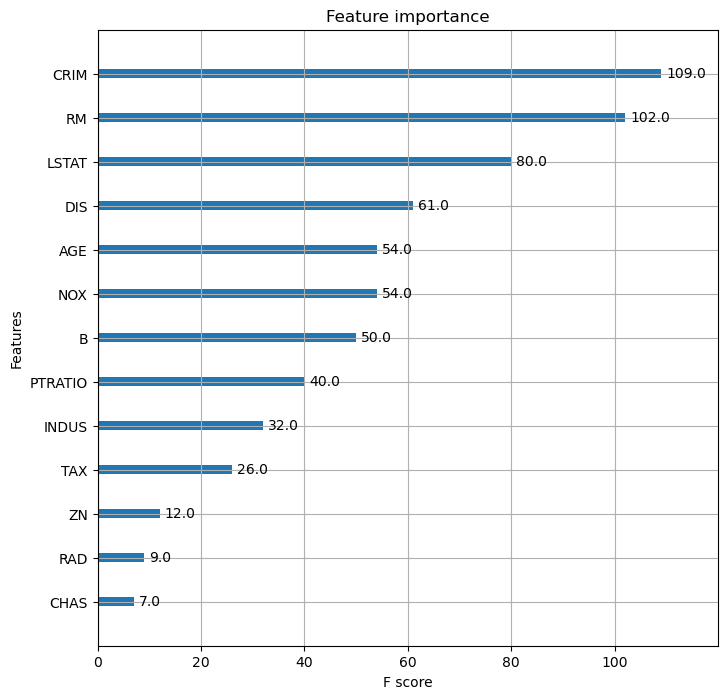

In [216]:

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [8,8]


CRIM: per capita crime rate by town

ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS: proportion of non-retail business acres per town

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX: nitric oxides concentration (parts per 10 million)

RM: average number of rooms per dwelling

AGE: proportion of owner-occupied units built prior to 1940

DIS: weighted distances to five Boston employment centres

RAD: index of accessibility to radial highways

TAX: full-value property-tax rate per $10,000

PTRATIO: pupil-teacher ratio by town

B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT: Proportion of population that is lower status = 1/2 (proportion of adults without, some high school education and proportion of male workers classified as laborers)

PRICE: Median value of owner-occupied homes in $1000's

Linear Regression

In [101]:
from sklearn.linear_model import LinearRegression

In [213]:
X, y = data.iloc[:,:-1],data.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [108]:
c = lr.intercept_

m = lr.coef_


In [196]:
from sklearn.metrics import r2_score


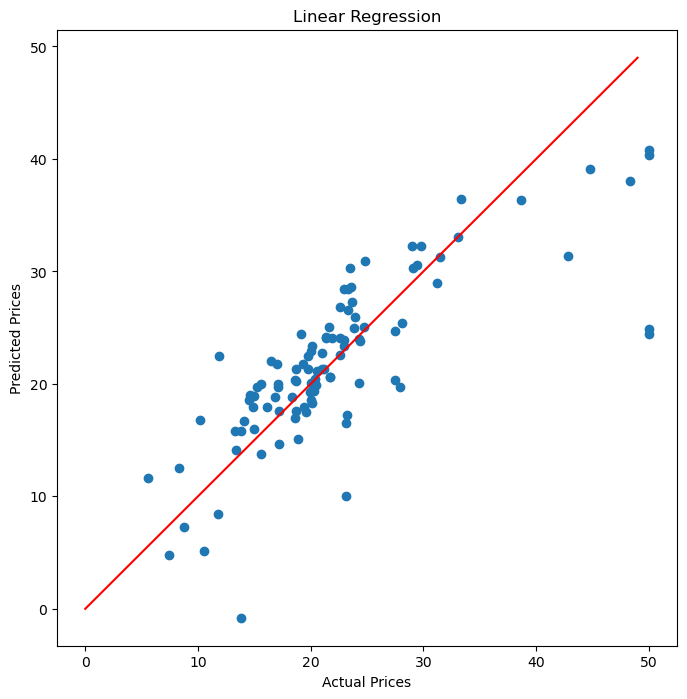

In [221]:
y_pred_test = lr.predict(X_test)
plt.scatter(y_test, y_pred_test)
plt.title('Linear Regression')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot(range(50), range(50), color = 'red');

In [215]:
r2_score(y_test, y_pred_test)

0.6592466510354089